In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models


In [ ]:
train_dir=r'/content/drive/MyDrive/train1'
val_dir=r'/content/drive/MyDrive/val'
test_dir=r'/content/drive/MyDrive/test'

In [ ]:
!pip install Pillow

In [ ]:
import os
import numpy as np
from PIL import Image

def load_x_ray_data(train_dir, val_dir, test_dir):
    """Loads X-ray image data from specified directories.

    Args:
        train_dir: Path to the training data directory.
        val_dir: Path to the validation data directory.
        test_dir: Path to the test data directory.

    Returns:
        A dictionary containing training, validation, and test data and labels.
    """
    def load_images_from_dir(dir_path):
        images = []
        labels = []
        for class_folder in os.listdir(dir_path):
            class_path = os.path.join(dir_path, class_folder)
            if os.path.isdir(class_path):
                for image_file in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_file)
                    try:
                        # Load image and convert to grayscale
                        image = Image.open(image_path).convert('L')
                        # Resize image to a desired size (e.g., 224x224)
                        image = image.resize((224, 224))
                        # Convert image to numpy array
                        image_array = np.array(image)
                        # Append image and label
                        images.append(image_array)
                        labels.append(class_folder)  # Assuming folder names are class labels
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")
        return images, labels
    # Load data from each directory
    train_images, train_labels = load_images_from_dir(train_dir)
    val_images, val_labels = load_images_from_dir(val_dir)
    test_images, test_labels = load_images_from_dir(test_dir)
    # Convert to numpy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    val_images = np.array(val_images)
    val_labels = np.array(val_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    # Store data in a dictionary
    x_ray_data = {
        'train_images': train_images,
        'train_labels': train_labels,
        'val_images': val_images,
        'val_labels': val_labels,
        'test_images': test_images,
        'test_labels': test_labels
    }
    return x_ray_data

In [ ]:
x_ray_data = load_x_ray_data(train_dir, val_dir, test_dir)  # Assuming you have a function to load X-ray data



In [ ]:
print(x_ray_data)

{'train_images': array([[[111, 109, 110, ...,  84,  77,  70],
        [108, 109, 111, ...,  82,  78,  71],
        [105, 109, 113, ...,  82,  78,  73],
        ...,
        [ 10,   9,   8, ...,  76,  75,  72],
        [ 10,   9,   8, ...,  74,  71,  81],
        [ 10,   9,   8, ...,  76,  72,  82]],

       [[117, 122, 125, ...,  96,  96,  93],
        [116, 125, 128, ...,  94,  90,  87],
        [114, 122, 130, ...,  98,  95,  90],
        ...,
        [108, 111, 108, ...,  10,   5,   6],
        [106, 118, 112, ...,   8,   5,   6],
        [103, 112, 115, ...,  10,   5,   5]],

       [[ 87,  92,  94, ...,  75,  73,  72],
        [ 87,  92,  95, ...,  74,  73,  72],
        [ 85,  90,  95, ...,  74,  73,  71],
        ...,
        [117, 119, 115, ...,  15,  14,  14],
        [118, 118, 116, ...,  17,  15,  12],
        [117, 116, 117, ...,  17,  14,  12]],

       ...,

       [[ 32,  36,  35, ...,  53,  52,  52],
        [ 30,  33,  36, ...,  52,  53,  53],
        [ 32,  34,  35, .

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')



validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [ ]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Get a batch of images and labels from the generator
X_batch, y_batch = next(train_generator)


# Reshape the image data for scaling
X_batch_reshaped = X_batch.reshape(X_batch.shape[0], -1)  # Flatten the images

# Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_batch_reshaped)

# Reshape the scaled data back to the original image shape
X_scaled = X_scaled.reshape(X_batch.shape)

# Standardization (similar process)
scaler = StandardScaler()
X_scaled_std = scaler.fit_transform(X_batch_reshaped)
X_scaled_std = X_scaled_std.reshape(X_batch.shape)



In [ ]:

from tensorflow.keras.applications import ResNet50
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(224, 224, 3)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,279,365 (187.99 MB)

 Trainable params: 49,226,245 (187.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
!pip install scikeras
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier  # Import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow import keras
from tensorflow.keras import layers, models

# ... (Your existing code for conv_base definition and param_dist) ...

# Define the create_model function that returns a compiled Keras model
def create_model(optimizer='adam',  # Default optimizer
                loss='sparse_categorical_crossentropy',  # Default loss function
                metrics=['accuracy']):  # Default metrics
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(224, 224, 3)))
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


# Wrap your Keras model with KerasClassifier
# Instead of passing the model directly, pass the create_model function
model = KerasClassifier(model=create_model,
                        optimizer='adam',  # Specify optimizer
                        loss='sparse_categorical_crossentropy',  # Specify loss function
                        metrics=['accuracy'])  # Specify metrics


# Create a RandomizedSearchCV object, specifying 'accuracy' as the scoring metric
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=3,
                                   scoring='accuracy')  # Add scoring='accuracy'


# **Change here:** Use flow_from_directory (or flow) to get data for fitting
# Assuming 'train_datagen' is an ImageDataGenerator for your training data
# and 'train_dir' is the path to your training data directory
# Adjust parameters as needed for your specific data and ImageDataGenerator setup
train_generator= train_datagen.flow_from_directory(
    train_dir,  # Replace with your training data directory
    target_size=(224, 224),  # Adjust if needed
    batch_size=32,  # Adjust if needed
    class_mode='sparse'  # Adjust if needed
)


# Fit the random search to the data
# **Change here:** Pass X and y to fit, unpacking them from the generator
# **Note:** This assumes that train_generator yields (X, y) tuples
# You might need to adjust this if your generator yields something different
# random_search_result = random_search.fit(train_generator)
for i in train_generator:
    random_search_result = random_search.fit(i)
    break  # This will only use the first batch for fitting, adjust if needed

# Print the best parameters and score
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

Found 5778 images belonging to 5 classes.


ValueError: Cannot have number of splits n_splits=3 greater than the number of samples: n_samples=2.

In [ ]:
from tensorflow.keras import optimizers
optimizer=optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("CNN_model-{epoch:02d}.keras")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [ ]:
history=model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[checkpoint_cb,early_stopping_cb]
)

Epoch 1/10
33/50 ━━━━━━━━━━━━━━━━━━━━ 8:15 29s/step - accuracy: 0.3062 - loss: 20.5215

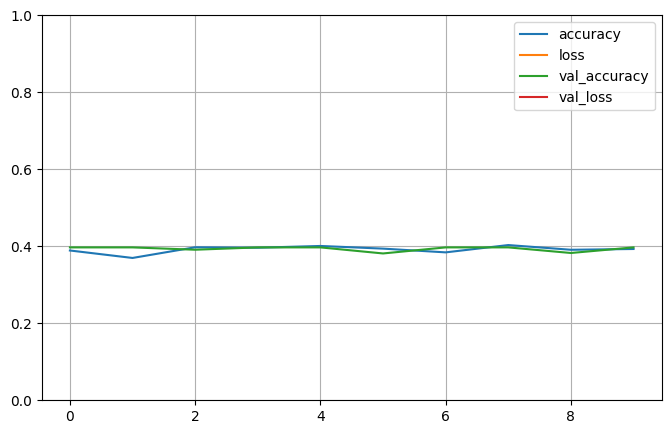

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')
model.evaluate(test_generator,steps=50)

Found 1656 images belonging to 5 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 859s 17s/step - accuracy: 0.3846 - loss: 1.4207


[1.4122799634933472, 0.38499999046325684]